# POS Chunking
**1. Create a chunker that detects noun-phrases (NPs) and lists the NPs in the text below.**

- Both [NLTK](https://www.nltk.org/book/ch07.html) and [spaCy](https://spacy.io/api/matcher) supports chunking
- Look up RegEx parsing for NLTK and the document object for spaCy.
- Make use of what you've learned about tokenization.

In [1]:
import spacy 
import nltk

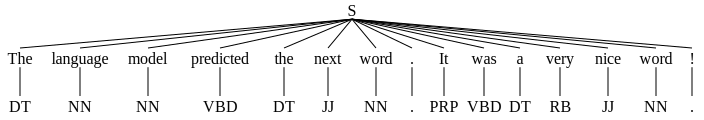

In [2]:
text = "The language model predicted the next word. It was a very nice word!"

tokens = nltk.word_tokenize(text)
tagged_tokens = nltk.pos_tag(tokens)
chunked_tokens = nltk.ne_chunk(tagged_tokens)

chunked_tokens

**2. Modify the chunker to handle verb-phases (VPs) as well.**
- This can be done by using a RegEx parser in NLTK or using a spaCy Matcher.

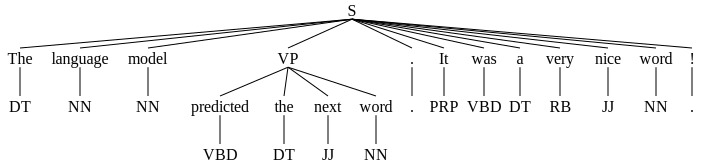

In [3]:
# TODO: set up grammars to chunk VPs

grammar = """
    VP: {<VB.*><DT>?<JJ>*<NN><IN>?<DT>?<JJ>*<NN>?}
"""

regex_chunker = nltk.RegexpParser(grammar)
regex_chunks = regex_chunker.parse(tagged_tokens)

regex_chunks

**3. Verb-phrases (VPs) can be defined by many different grammatical rules. Give four examples.**
- Hint: Context-Free Grammars, chapter 8 in NLTK.

VP -> V Adj | V NP | V S | V NP PP

(I hope this is what you mean by rules. Taken verbatim from NLTK CH8.)

**4. After these applications, do you find chunking to be beneficial in the context of language modeling and next-word prediction? Why or why not?**

Chunking seems to be very beneficial when it comes to constructing phrases from our tokens. Tokens alone are not very informative and miss context, especially in phrases that are longer. Chunking helps us build relationships between these tokens and give our sentence a grammatical structure. 

When it comes to next word prediction, chunking can help eliminate the problem of simply predicting the next word based on the previous word. In combination with parts of speech tagging, we can predict the next word based on the previous word and the type of phrase we are in. This can help us predict the next word more accurately.

___

# Dependency Parsing

**1. Use spaCy to inspect/visualise the dependency tree of the text provided below.**
- Optional addition: visualize the dependencies as a graph using `networkx`

In [4]:
from spacy import displacy

In [5]:
text = "The language model predicted the next word"
nlp = spacy.load("en_core_web_sm")

pipeline = nlp(text)

displacy.render(pipeline, style='dep', jupyter=True, page=True, options={'compact': True})

**2. What is the root of the sentence? Attempt to spot it yourself, but the answer should be done by code**

In [6]:
def root_finder(doc):
    for token in doc:
        if token.dep_ == "ROOT":
            return token.text, token.pos_
            
root_finder(pipeline)

('predicted', 'VERB')

**3. Find the subject and object of a sentence. Print the results for the sentence above.**

In [7]:
def subject_object_finder(doc):
    for token in doc:
        if token.dep_ in ["nsubj", "dobj"]:
            print(token.text, token.dep_, token.head.text, token.head.pos_, [child for child in token.children])

subject_object_finder(pipeline)

model nsubj predicted VERB [The, language]
word dobj predicted VERB [the, next]


**4. How would you use the relationships extracted from dependency parsing in language modeling contexts?**

By building relationships and dependencies between words, we can extract information in a more systematic and accurate way by pinpointing the relevant parts of a sentence and what their actions/context is.

___

# Wordnet

**1. Use Wordnet (from NLTK) and create a function to get all synonyms of a word of your choice. Try with "language"**

In [9]:
from nltk.corpus import wordnet as wn

word = "language"

def get_syns(word):
    syns = wn.synsets(word)[0]
    synonyms = syns.synonyms()
    return synonyms

get_syns(word)

[Lemma('language.n.01.language'),
 Lemma('language.n.01.linguistic_communication')]

**2. From the same word you chose, extract an additional 4 or more features from wordnet (such as hyponyms). Describe each category briefly.**

In [9]:
def get_features(word):
    features = []
    synset  = wn.synsets(word) 
    
    features.append(synset[0].definition()) # definition of the word
    features.append(synset[0].examples()) # examples using that word
    features.append(synset[0].hypernyms()) # hypernyms of the word, i.e. more general words
    features.append(synset[0].hyponyms()) # hypoynms of the word, i.e. more specific words
    
    return features

get_features(word)

['a systematic means of communicating by the use of sounds or conventional symbols',
 ['he taught foreign languages',
  'the language introduced is standard throughout the text',
  'the speed with which a program can be executed depends on the language in which it is written'],
 [Synset('communication.n.02')],
 [Synset('artificial_language.n.01'),
  Synset('barrage.n.01'),
  Synset('dead_language.n.01'),
  Synset('indigenous_language.n.01'),
  Synset('lingua_franca.n.01'),
  Synset('metalanguage.n.01'),
  Synset('native_language.n.01'),
  Synset('natural_language.n.01'),
  Synset('object_language.n.02'),
  Synset('sign_language.n.01'),
  Synset('slanguage.n.01'),
  Synset('source_language.n.01'),
  Synset('string_of_words.n.01'),
  Synset('superstrate.n.02'),
  Synset('usage.n.03'),
  Synset('words.n.03')]]

___

# Machine Learning Exercise - A sentiment classifier
- A rule-based approach with SentiWordNet + A machine learning classifier

**1. There are several steps required to build a classifier or any sort of machine learning application for textual data. For data including (INPUT_TEXT, LABEL), list the typical pipeline for classification.**

Initially we'd like to extract the relevant features from the text - probably with a tokenization method. What follows is stopword removal, potentially lemmatization, and finally using pre-trained word embeddings to represent each word-feature. We then end up with a list of features per text and its label - a representation easily processable by ML classifiers.

**2. Before developing a classifier, having a baseline is very useful. Build a baseline model for sentiment classification using SentiWordNet.**
- How you decide to aggregate sentiment is up to you. Explain your approach.
- It should report the accuracy of the classifier.

In [10]:
nltk.download('sentiwordnet')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/dion/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [11]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
import spacy
import math


def get_sentiment(sentences):
    labels = []
    for s in sentences:
        pipeline = nlp(s)
        sentence_score = 0
        label = 0
        for w in pipeline:
            syns = wn.synsets(w.text)
            if len(syns) == 0:
                continue 
            
            main_meaning = syns[0]
            sent = swn.senti_synset(main_meaning.name())
            
            sentence_score += sent.pos_score()
            sentence_score -= sent.neg_score()
        if sentence_score >= 0:
            label = 1
        labels.append(label)
        
    return labels
        
def get_accuracy(pred, labels):
    assert len(pred) == len(labels)
    
    return sum([1 for i in range(len(pred)) if pred[i] == labels[i]]) / len(pred)

# Evaluate it on the following sentences:
sents = [
    "I liked it! Did you?",
    "It's not bad but... Nevermind, it is.",
    "It's awful",
    "I don't care if you loved it - it was terrible!",
    "I don't care if you hated it, I think it was awesome"
]
# 0: negative, 1: positive
y_true = [1, 0, 0, 0, 1]

y_preds = get_sentiment(sents)

get_accuracy(y_preds, y_true)

1.0

Looks like it's super accuracte!

What we're doing is extracting the words from a sentence and if their meaning exists, we check its sentiment and aggregate it for the whole sentence. If the score is under 0, we label it as 0 (negative) and if it's over 0, we label the sentence as positive - else it's negative.

## The SST-2 binary sentiment dataset

**3. Split the training set into a training and test set. Choose a split size, and justify your choice.**

In [12]:
from datasets import load_dataset
dataset = load_dataset("sst2")

train_df = dataset["train"].to_pandas().drop(columns=["idx"])
train_df = train_df.sample(10000)  # a tiny subset
print(train_df.label.value_counts())
train_df.head()

label
1    5552
0    4448
Name: count, dtype: int64


,sentence,label
49803,an entertaining ride,1
44530,nettelbeck has crafted an engaging fantasy of ...,1
5576,of a genuine and singular artist,1
51468,"dull , simple-minded and stereotypical",0
24983,make it an above-average thriller,1


In [13]:
# let's shuffle first
train_df = train_df.sample(frac=1)

We'll do a 80-20 split, as it's pretty standard and the testing dataset shouldn't be as big as the training set. 

In [14]:
test_df = train_df.iloc[8000:, :]
train_df = train_df.iloc[:8000, :]

In [15]:
x_train = train_df["sentence"].tolist()
y_train = train_df["label"].tolist()

x_test = test_df["sentence"].tolist()
y_test = test_df["label"].tolist()

**4. Evaluate your baseline model on the test set.**

- Additionally: compare it against a random baseline. That is, a random guess for each example

In [16]:
from random import randint

def random_sent(x_data):
    preds = []
    for _ in x_data:
        preds.append(randint(0, 1))
    return preds

In [17]:
y_preds_random = random_sent(x_test)
y_preds_mine = get_sentiment(x_test)

print(f"Random accuracy {get_accuracy(y_preds_random, y_test)}")
print(f"My Accuracy {get_accuracy(y_preds_mine, y_test)}")

Random accuracy 0.481
My Accuracy 0.6635


**5. Did you beat random guess?**

If not, can you think of any reasons why?

Slightly beat it! My classifier is not sophisticated at all, yet it is sometimes able to catch sentiment based on the algorithm I developed better than simply random guessing. Not really worth the effort, though.

## Classification with Naive Bayes and TF-IDF
This is the final task of the lab. You will use high-level libraries to implement a TF-IDF vectorizer and train your data using a Naive Bayes classifier

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import numpy as np

pipeline = Pipeline([
        ('n', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

pipeline.fit(x_train, y_train)
y_preds = pipeline.predict(x_test)


print(f"Accuracy: {np.mean(y_preds == y_test)}")
print(classification_report(y_test, y_preds))

Accuracy: 0.817
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       868
           1       0.80      0.90      0.85      1132

    accuracy                           0.82      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.82      0.82      0.81      2000



All is as expected!

## Optional task: using a pre-trained transformer model
If you wish to push the accuracy as far as you can, take a look at BERT-based or other pre-trained language models. As a starting point, take a look at a model already fine-tuned on the SST-2 dataset: [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english)

**Advanced:**

Going beyond this, you could look into the addition of a *classification head* on top of the pooling layer of a BERT-based model. This is a common approach to fine-tuning these models on classification or regression problems.